In [28]:
import yfinance as yf
import pandas as pd
import numpy as np


# Download ~60 days M15 = 5000+ bars
ticker = 'EURUSD=X'
df = yf.download(ticker, period='60d', interval='15m', auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close']].dropna()
print(f"Loaded {len(df):,} M15 bars: {df.index[0].date()} to {df.index[-1].date()}")


[*********************100%***********************]  1 of 1 completed

Loaded 5,585 M15 bars: 2025-09-15 to 2025-12-05


In [50]:
import talib
import numpy as np
import pandas as pd

# Fix MultiIndex columns - extract just the price data
df.columns = [col[0] for col in df.columns]  # ['Open', 'High', 'Low', 'Close']

# Now convert to proper 1D arrays
close = df['C'].values
high = df['H'].values
low = df['L'].values

# TA-Lib will now work
macd, signal, hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['RSI'] = talib.RSI(close, timeperiod=14)
df['ATR'] = talib.ATR(high, low, close, timeperiod=14)

df = df.dropna().reset_index(drop=True)
print(f"After indicators: {len(df):,} bars")


After indicators: 5,486 bars


In [51]:
def generate_labels(df, mult=0.5, RR=2):

    print(f"Processing multiplier {mult}...")
    labels = pd.Series(index=df.index, dtype=int)
    
    for i in range(1, len(df)):  # Start after indicator warmup, leave lookahead
        # ENTRY at OPEN of current bar i
        entry_price = df['O'].iloc[i]
        
        # FEATURES from PREVIOUS closed bar (i-1)
        prev_macd = df['MACD'].iloc[i-1]
        prev_rsi = df['RSI'].iloc[i-1]
        prev_atr = df['ATR'].iloc[i-1]
        
        # Skip if any feature NaN
        if pd.isna(prev_macd) or pd.isna(prev_rsi) or pd.isna(prev_atr):
            continue
            
        sl_distance = mult * prev_atr
        tp_distance = RR*mult * prev_atr
        
        # Simulate forward from CURRENT bar i+1 onwards
        future_bars = df.iloc[i+1:i+51]  # Max 50 bars lookahead
        if len(future_bars) < 5:  # Need minimum bars
            continue
            
        highs = future_bars['H']
        lows = future_bars['L']
        
        # Check BUY: TP hits before SL
        tp_buy_level = entry_price + tp_distance
        sl_buy_level = entry_price - sl_distance
        
        buy_tp_idx = highs[highs >= tp_buy_level].index.min() if (highs >= tp_buy_level).any() else None
        buy_sl_idx = lows[lows <= sl_buy_level].index.min() if (lows <= sl_buy_level).any() else None
        
        buy_win = False
        if buy_tp_idx is not None and buy_sl_idx is not None:
            buy_win = buy_tp_idx < buy_sl_idx  # TP first
        elif buy_tp_idx is not None:
            buy_win = True  # TP hit, no SL
        
        # Check SELL: SL (resistance) hits before TP (support)  
        tp_sell_level = entry_price - tp_distance
        sl_sell_level = entry_price + sl_distance
        
        sell_tp_idx = lows[lows <= tp_sell_level].index.min() if (lows <= tp_sell_level).any() else None
        sell_sl_idx = highs[highs >= sl_sell_level].index.min() if (highs >= sl_sell_level).any() else None
        
        sell_win = False
        if sell_tp_idx is not None and sell_sl_idx is not None:
            sell_win = sell_tp_idx < sell_sl_idx  # TP first
        elif sell_tp_idx is not None:
            sell_win = True  # TP hit, no SL
        
        # STRING LABELS: "buy", "sell", or NaN
        if buy_win and sell_win:
            labels.iloc[i] = 0  # Both win: neutral/do nothing
        elif buy_win:
            labels.iloc[i] = 1  # Buy only
        elif sell_win:
            labels.iloc[i] = -1  # Sell only
        else:
            labels.iloc[i] = 0  # Neither: neutral [web:2]
    

    return labels.rename('label')

# Generate labels
mult = 2
RR=2
labels_df = generate_labels(df ,mult, RR)
print("Sample data:")
print(df[['MACD', 'RSI', 'ATR']].assign(label=labels_df).head(10))
print(df[['MACD', 'RSI', 'ATR']].assign(label=labels_df).tail(10))


Processing multiplier 2...
Sample data:
       MACD        RSI       ATR  label
0  0.000182  62.100108  0.000477    NaN
1  0.000199  63.345587  0.000473   -1.0
2  0.000187  59.156681  0.000469   -1.0
3  0.000108  48.750295  0.000496   -1.0
4  0.000034  47.258777  0.000471   -1.0
5 -0.000036  45.752575  0.000457   -1.0
6 -0.000101  44.234319  0.000435   -1.0
7 -0.000163  42.708075  0.000434   -1.0
8 -0.000198  44.760645  0.000423   -1.0
9 -0.000223  44.760645  0.000413   -1.0
          MACD        RSI       ATR  label
5476 -0.000144  46.086769  0.000438    0.0
5477 -0.000139  46.086769  0.000426    0.0
5478 -0.000122  48.727583  0.000415    0.0
5479 -0.000108  48.727583  0.000405    0.0
5480 -0.000084  51.486005  0.000396    0.0
5481 -0.000076  48.666385  0.000377    NaN
5482 -0.000079  45.958264  0.000379    NaN
5483 -0.000081  45.958264  0.000371    NaN
5484 -0.000081  45.958264  0.000345    NaN
5485 -0.000081  45.958264  0.000320    NaN


In [54]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Split 20% test set (final 20% chronological)
test_size = int(len(df) * 0.2)
train_val_df = df.iloc[:-test_size].copy()
test_df = df.iloc[-test_size:].copy()

print(f"Train+Val: {len(train_val_df):,} bars, Test: {len(test_df):,} bars")

results = {}

# Fixed window CV
tscv = TimeSeriesSplit(
    n_splits=20,          
    max_train_size=500,   
    test_size=200         
)

feature_cols = ['MACD', 'RSI']
label_col = f'label'

# === CLEAN DATA - Proper Series access ===
print("Cleaning data - removing NaN in features or labels...")

# Train+Val cleaning - USE DOT/COMMA NOT BRACKETS FOR SERIES
train_val_clean = (
    train_val_df[feature_cols].notna().all(axis=1) & 
    labels_df.loc[train_val_df.index].notna()  # ✅ Series direct access
)
X = train_val_df.loc[train_val_clean, feature_cols].copy()
y = labels_df.loc[X.index].copy()  # ✅ Series access

print(f"Clean Train+Val - X: {X.shape}, y: {y.shape}")
print(f"y value counts:\n{y.value_counts().sort_index()}")

# Test cleaning
test_clean = (
    test_df[feature_cols].notna().all(axis=1) & 
    labels_df.loc[test_df.index].notna()  # ✅ Series direct access
)
X_test_clean = test_df.loc[test_clean, feature_cols].copy()
y_test_clean = labels_df.loc[X_test_clean.index].copy()  # ✅ Series access

print(f"Clean Test - X_test: {X_test_clean.shape}, y_test: {y_test_clean.shape}")

# Initialize totals
total_train_holds, total_train_buys, total_train_sells = 0, 0, 0
total_val_holds, total_val_buys, total_val_sells = 0, 0, 0

scores = []
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Count classes
    train_holds = (y_train == 0).sum()
    train_buys = (y_train == 1).sum()
    train_sells = (y_train == -1).sum()
    val_holds = (y_val == 0).sum()
    val_buys = (y_val == 1).sum()
    val_sells = (y_val == -1).sum()
    
    # Update totals
    total_train_holds += train_holds
    total_train_buys += train_buys
    total_train_sells += train_sells
    total_val_holds += val_holds
    total_val_buys += val_buys
    total_val_sells += val_sells
    
    print(f"Fold {fold_num}:")
    print(f"  Training set: {train_idx[0]}-{train_idx[-1]} ({len(train_idx)} samples)")
    print(f"    Holds: {train_holds}, Buys: {train_buys}, Sells: {train_sells}")
    print(f"  Validation set: {val_idx[0]}-{val_idx[-1]} ({len(val_idx)} samples)")
    print(f"    Holds: {val_holds}, Buys: {val_buys}, Sells: {val_sells}")
    print()
    
    model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20, 
                                  class_weight={-1:1, 0:1, 1:1})
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    scores.append(score)

# Print totals
print("Total counts across all folds:")
print(f"  Training - Holds: {total_train_holds}, Buys: {total_train_buys}, Sells: {total_train_sells}")
print(f"  Validation - Holds: {total_val_holds}, Buys: {total_val_buys}, Sells: {total_val_sells}")

cv_score = np.mean(scores)
results[mult] = cv_score
print(f"CV Accuracy: {cv_score:.3f} (+/- {np.std(scores)*2:.3f})")

# === FINAL TEST EVALUATION ===
print(f"\n{'='*50}")
print(f"FINAL TEST: Multiplier {mult}")
print(f"{'='*50}")

# Train final model on ALL clean train+val data
final_model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20, 
                                    class_weight={-1:1, 0:1, 1:1})
final_model.fit(X, y)  # Already clean!

# Test predictions
y_pred = final_model.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred, target_names=['Hold', 'Sell', 'Buy'], zero_division=0))
print(f"Test Accuracy: {final_model.score(X_test_clean, y_test_clean):.3f}")


Train+Val: 4,389 bars, Test: 1,097 bars
Cleaning data - removing NaN in features or labels...
Clean Train+Val - X: (4388, 2), y: (4388,)
y value counts:
label
-1.0    1296
 0.0    1826
 1.0    1266
Name: count, dtype: int64
Clean Test - X_test: (1092, 2), y_test: (1092,)
Fold 1:
  Training set: 0-387 (388 samples)
    Holds: 135, Buys: 123, Sells: 130
  Validation set: 388-587 (200 samples)
    Holds: 84, Buys: 23, Sells: 93

Fold 2:
  Training set: 88-587 (500 samples)
    Holds: 195, Buys: 111, Sells: 194
  Validation set: 588-787 (200 samples)
    Holds: 84, Buys: 69, Sells: 47

Fold 3:
  Training set: 288-787 (500 samples)
    Holds: 192, Buys: 165, Sells: 143
  Validation set: 788-987 (200 samples)
    Holds: 83, Buys: 82, Sells: 35

Fold 4:
  Training set: 488-987 (500 samples)
    Holds: 221, Buys: 156, Sells: 123
  Validation set: 988-1187 (200 samples)
    Holds: 74, Buys: 94, Sells: 32

Fold 5:
  Training set: 688-1187 (500 samples)
    Holds: 188, Buys: 228, Sells: 84
  Vali

In [56]:
def verify_alignment(X_test, y_test, y_pred):
    print("🔍 ALIGNMENT CHECK:")
    print(f"  Shapes: X={X_test.shape}, y={y_test.shape}, pred={y_pred.shape}")
    print(f"  Indices match: {X_test.index.equals(y_test.index)}")
    print(f"  Sample: pred[0]={y_pred[0]}, actual[0]={y_test.values[0]}, date={X_test.index[0]}")
    assert len(X_test) == len(y_test) == len(y_pred), "ALIGNMENT FAILED!"
    print("✅ READY FOR EQUITY CURVE")

# Use it:
verify_alignment(X_test_clean, y_test_clean, y_pred)

🔍 ALIGNMENT CHECK:
  Shapes: X=(1092, 2), y=(1092,), pred=(1092,)
  Indices match: True
  Sample: pred[0]=1.0, actual[0]=0.0, date=4389
✅ READY FOR EQUITY CURVE



SIMPLE EQUITY CURVE
Total Signal Trades: 578
Wins: 203 (35.1% win rate)
Final Balance: $103,100
Total Return: 3.1%
Max Drawdown: -6.3%
Profit Factor: 1.08


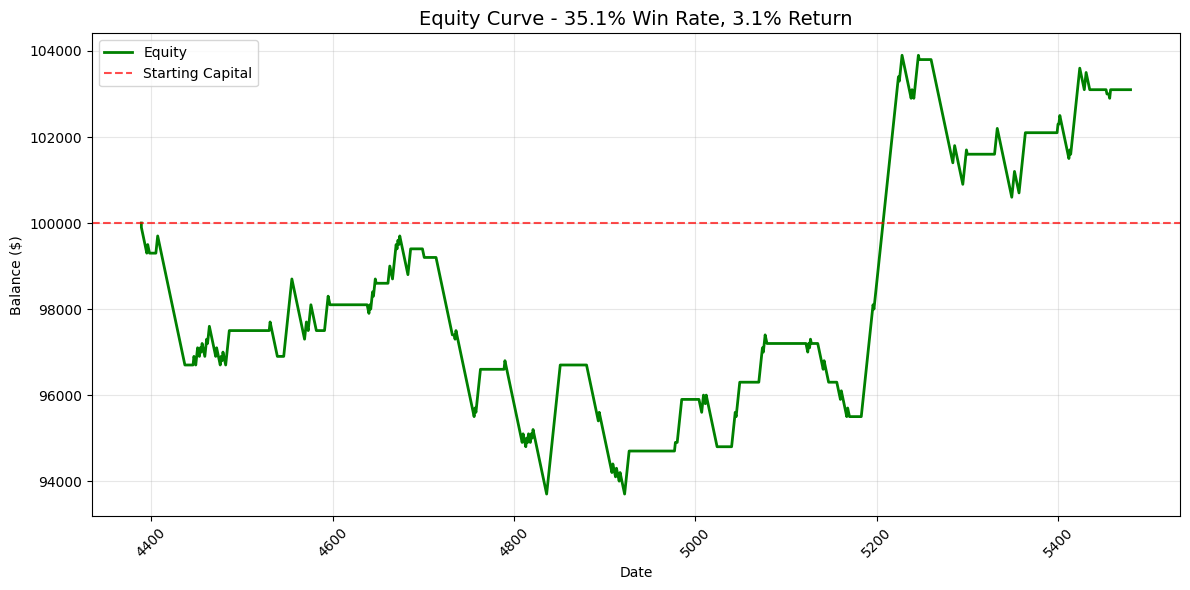

In [57]:
print(f"\n{'='*60}")
print(f"SIMPLE EQUITY CURVE")
print(f"{'='*60}")

risk_per_trade = 100  # 1% of 100k capital

# Generate predictions
y_pred = final_model.predict(X_test_clean)
y_test_np = y_test_clean.values  # pandas Series -> numpy array

# Simulate balance curve - ONLY on signal predictions
balance = 100000  # Starting capital
equity_curve = [balance]
dates = [X_test_clean.index[0]] if len(X_test_clean) > 0 else []
wins=0
total_signal_trades=0

for i in range(len(y_test_np)):
    pred = y_pred[i]
    actual = y_test_np[i]

    # Only trade on Buy/Sell signals
    if pred == 1 or pred == -1:
        total_signal_trades += 1
        if pred == actual:  # Win
            wins += 1
            balance += RR * risk_per_trade
        else:  # Loss
            balance -= risk_per_trade

    # Append current balance and date regardless of trade or hold
    equity_curve.append(balance)
    dates.append(X_test_clean.index[i])


# Create results DataFrame
equity_df = pd.DataFrame({'date': dates, 'balance': equity_curve})
equity_df['return_pct'] = equity_df['balance'].pct_change() * 100

# Key metrics (signal-only trades)
win_rate = wins / total_signal_trades if total_signal_trades > 0 else 0

total_return = (balance / 100000 - 1) * 100
max_dd = ((equity_df['balance'].cummax() - equity_df['balance']) / equity_df['balance'].cummax() * 100).max()

print(f"Total Signal Trades: {total_signal_trades}")
print(f"Wins: {wins} ({win_rate:.1%} win rate)")
print(f"Final Balance: ${balance:,.0f}")
print(f"Total Return: {total_return:.1f}%")
print(f"Max Drawdown: -{max_dd:.1f}%")
print(f"Profit Factor: {RR * win_rate / (1 - win_rate):.2f}" if win_rate < 1 else "Infinite")


# Plot equity curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(equity_df['date'], equity_df['balance'], linewidth=2, color='green', label='Equity')
plt.axhline(y=100000, color='red', linestyle='--', alpha=0.7, label='Starting Capital')
plt.title(f'Equity Curve - {win_rate:.1%} Win Rate, {total_return:.1f}% Return', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Balance ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
print("Model classes:", final_model.classes_)
# Expected: [-1  0  1]
print("Correct class_names:", ['Sell', 'Hold', 'Buy'])

Model classes: [-1.  0.  1.]
Correct class_names: ['Sell', 'Hold', 'Buy']


Feature Importance:
MACD: 0.802
RSI: 0.198


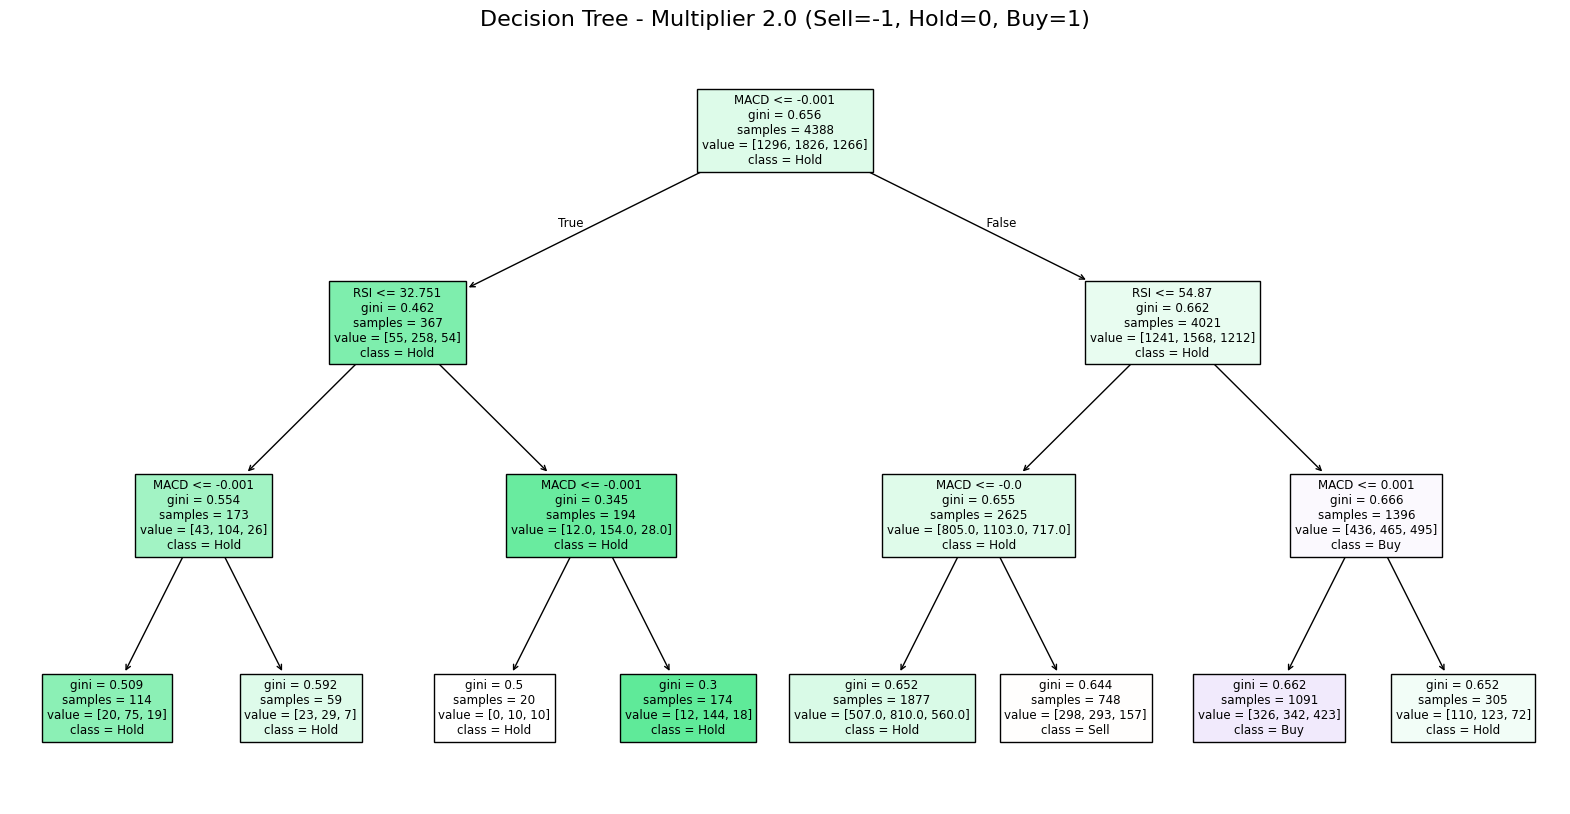

In [61]:
# Feature importance (PERFECT ✅)
print("Feature Importance:")
for name, score in zip(feature_cols, final_model.feature_importances_):
    print(f"{name}: {score:.3f}")

# Tree visualization (CORRECTED)
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(final_model, 
          feature_names=feature_cols, 
          class_names=['Sell', 'Hold', 'Buy'],  # ✅ Matches [-1, 0, 1] order
          max_depth=3, 
          filled=True)
plt.title("Decision Tree - Multiplier 2.0 (Sell=-1, Hold=0, Buy=1)", fontsize=16)
plt.show()
